In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns 
import haiku as hk

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

from scipy.optimize import linear_sum_assignment

In [2]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"

def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )

def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9), pca=None): 
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  print(residuals.shape)
  if pca is not None: 
    old = residuals.shape[:-1]
    residuals = pca.transform(residuals.reshape(-1, residuals.shape[-1])).reshape(old + (-1,))
    print(residuals.shape)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [3]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [4]:
#@title: Assemble model
program_name = "sort_unique"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 10 #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

from tracr.datasets.generated_lib import program_1
assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      use_dropout=False, 
      embedding_size=None,
      unembed_at_every_layer=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

# dict_keys(['token_embed', 'pos_embed', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/value', 'transformer/layer_0/attn/linear', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/query', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/value', 'transformer/layer_1/attn/linear', 'transformer/layer_1/mlp/linear_1', 'transformer/layer_1/mlp/linear_2'])
# dict_keys(['token_embed', 'pos_embed', 'compressed_transformer/layer_0/attn/query', 'compressed_transformer/layer_0/attn/key', 'compressed_transformer/layer_0/attn/value', 'compressed_transformer/layer_0/attn/linear', 'compressed_transformer/layer_0/mlp/linear_1', 'compressed_transformer/layer_0/mlp/linear_2', 'compressed_transformer/layer_1/attn/query', 'compressed_transformer/layer_1/attn/key', 'compressed_transformer/layer_1/attn/value', 'compressed_transformer/layer_1/attn/linear', 'compressed_transformer/layer_1/mlp/linear_1', 'compressed_transformer/layer_1/mlp/linear_2'])


Compiling...
   Program: sort_unique
   Input vocabulary: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
   Context size: 10
Done.


In [5]:
#@title Forward pass
assembled_model.apply(["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10]).decoded
# assembled_model.apply(['bos', 'a', 'b', 'c', 'x']).decoded

['bos', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

(5, 1, 11, 45)


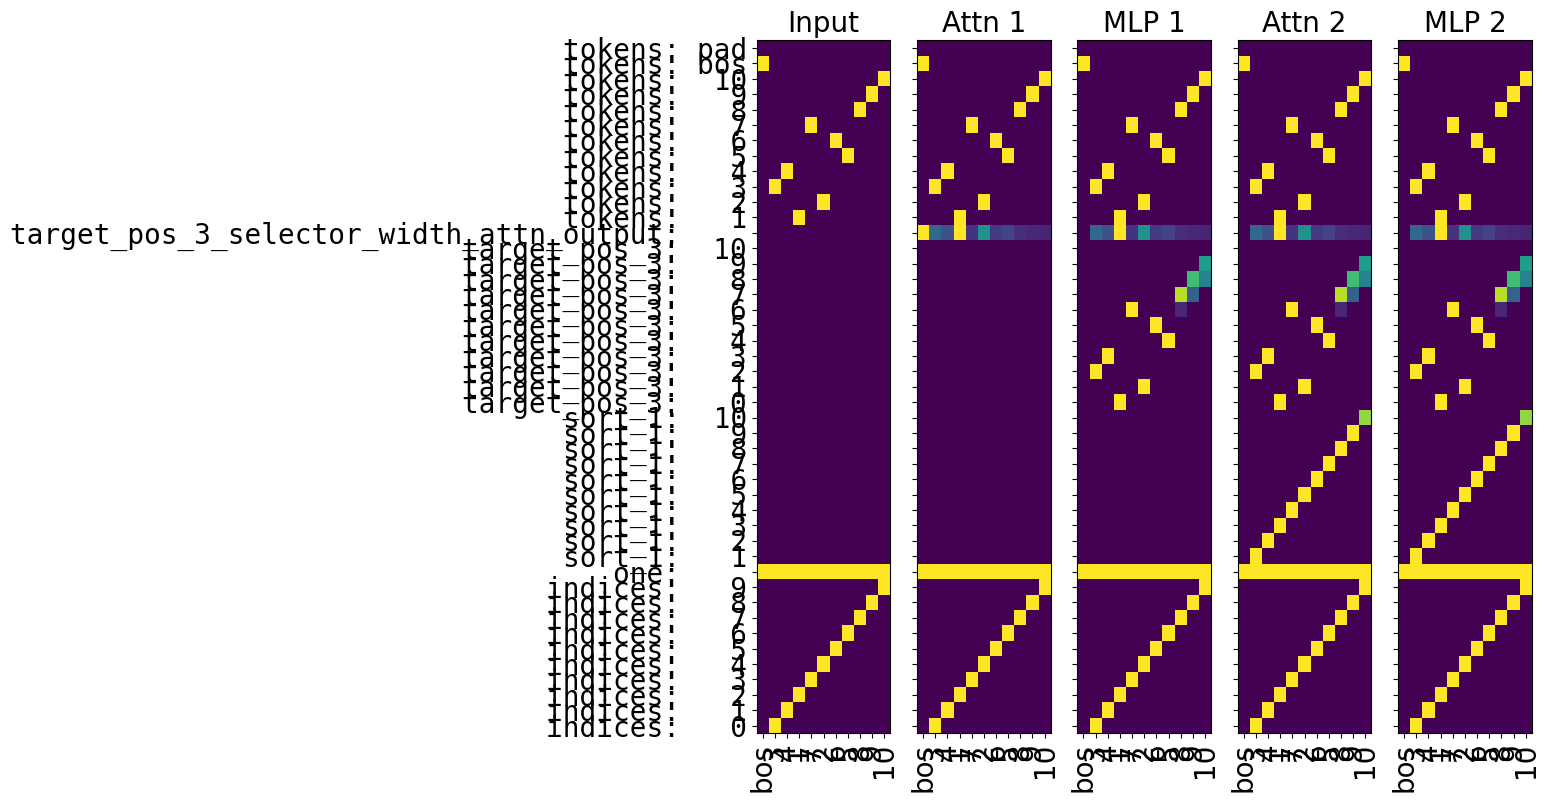

In [6]:
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10],
  figsize=(10, 9)
)

In [23]:
assembled_model.model_config

TransformerConfig(num_heads=1, num_layers=2, key_size=12, mlp_hidden_size=22, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7f176909d570>, layer_norm=False, causal=False, use_dropout=False, embedding_size=30, unembed_at_every_layer=False)

In [10]:
# residuals = np.load('data/activations/program_1.npy')
# residuals.shape

## Make dataset of examples

In [11]:
max_seq_len = 10
vocab = [i for i in range(1, max_seq_len + 1)]
program_name = 'sort_unique'

def get_permutations(vocab, rem_len, no_repeats=False):
    # base case
    if rem_len == 1: 
        return [[v] for v in vocab]
        
    res = []
    for v in vocab:
        if no_repeats:
            vocab = [v_ for v_ in vocab if v_ != v]
        perms = get_permutations(vocab, rem_len - 1)
        for p in perms: 
            p.append(v)
        res.extend(perms)
    return res


def get_permutations_via_sampling(vocab, max_len, num_samples, no_repeats=False): 
    """
    Works iteratively, want to sample uniformally from all permutations of length rem_len
    """
    if no_repeats: 
        assert num_samples <= np.math.factorial(max_len)
    else: 
        assert num_samples <= len(vocab) ** max_len
        
    permutations = []
    for _ in range(num_samples): 
        if no_repeats: 
            permutation = np.random.choice(vocab, size=max_len, replace=False)
        else:
            permutation = np.random.choice(vocab, size=max_len, replace=True)
        permutations.append(permutation)
    return permutations
        

dataset = get_permutations_via_sampling(vocab, max_seq_len, 1000, no_repeats=True)
dataset = [['bos'] + list(d) for d in dataset]

/tmp/ipykernel_497718/1651780678.py:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  assert num_samples <= np.math.factorial(max_len)


In [13]:
residuals = []
layer_outputs = []

for d in tqdm(dataset): 
      output = assembled_model.apply(d)
      residuals.append(output.residuals)
      layer_outputs.append(output.layer_outputs)
      decoded = output.decoded[1:]
      check = sorted(d[1:])
      assert decoded == check, f"Expected {check}, got {decoded}"

layer_outputs = np.array(layer_outputs).squeeze()
residuals = np.array(residuals).squeeze() 

print(residuals.shape)
# post_attn_1 = residuals[:, 1].squeeze()
all_residuals = residuals
print(all_residuals.shape)

# # combine dim 0 and 1 and 2
all_residuals = np.reshape(all_residuals, (-1, all_residuals.shape[-1]))

# # combine dim 0,1,2
# all_residuals = np.concatenate(all_residuals, axis=0)
# all_residuals = np.concatenate(all_residuals, axis=0)

print(all_residuals.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:33<00:00, 10.74it/s]


(1000, 4, 11, 45)
(1000, 4, 11, 45)
(44000, 45)


In [14]:
from sympy import Matrix

u_all_residuals = np.round(all_residuals, 2)
u_all_residuals = np.unique(u_all_residuals, axis=1)
print(u_all_residuals.shape)

(44000, 44)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch_dataset = torch.tensor(all_residuals, dtype=torch.float32)
batch_size = 128

train_set, test_set = torch.utils.data.random_split(all_residuals, [len(all_residuals) // 2, len(all_residuals) // 2])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [16]:
def greedy_distributional_distance(orig_features, decoder_features, no_duplicates=False): 
    """
    Returns a permutation of the decoder features that minimizes 
    the distance between the distribution of the original features
    and the distribution of the decoder features. Also returns the 
    final minimized distance. 

    orig_features: (num_samples, residual_dim)
    decoder_features: (num_samples, decoder_dim)
    """

    num_samples = orig_features.shape[0]
    residual_dim = orig_features.shape[1]    

    permutation = []
    guess = torch.zeros_like(orig_features)
    for i in range(residual_dim): 
        
        current = orig_features[:,i] # (num_samples, )
        # print(current.shape, decoder_features.shape)
        # print(orig_features.shape, decoder_features.shape)
        cosine_similarities = F.cosine_similarity(current.unsqueeze(1), decoder_features, dim=0)
        # print(cosine_similarities)
        best = torch.argmax(cosine_similarities).item()
        permutation.append(best)

        guess[:, i] = decoder_features[:, best]
        
        if no_duplicates: 
            decoder_features[:, best] = 0

    # print(guess)
    distance = torch.linalg.norm(orig_features - guess, dim=1, ord=1).mean().item()
    return permutation, distance

def reduce_via_sub(M, dim): 
    dim_min = torch.min(M, dim=dim, keepdim=True).values
    return M - dim_min

def cover_zeros(M):
    n = M.shape[0]
    covered_rows = torch.zeros(n, dtype=torch.bool)
    covered_cols = torch.zeros(n, dtype=torch.bool)
    
    zero_matrix = M == 0

    for r in range(n):
        for c in range(n):
            if zero_matrix[r, c] and not covered_rows[r] and not covered_cols[c]:
                covered_rows[r] = True
                covered_cols[c] = True
    
    return covered_rows, covered_cols

def adjust_matrix(M, covered_rows, covered_cols):
    n = M.shape[0]
    uncovered = ~(covered_rows.unsqueeze(1) | covered_cols)
    min_val = torch.min(M[uncovered]).item()
    M[uncovered] -= min_val
    M[covered_rows.unsqueeze(1) & covered_cols] += min_val
    return M

def hungarian_alg_distance(orig_features, decoder_features): 
    """
    Returns a permutation of the decoder features that minimizes
    the distance between the original features and the decoder features
    using the Hungarian algorithm. Also returns the final minimized distance.
    """
    # orig_features: (num_samples, residual_dim)
    # decoder_features: (num_samples, decoder_dim)
    # cosine_similarities: (residual_dim, decoder_dim)

    n = orig_features.shape[0]
    l = orig_features.shape[1]
    m = decoder_features.shape[0]

    cosine_similarities = orig_features.T @ decoder_features
    cosine_similarities = cosine_similarities / (torch.linalg.norm(orig_features, dim=1, keepdim=True).T @ torch.linalg.norm(decoder_features, dim=1, keepdim=True))
    print(cosine_similarities.shape)

    # pad cosine_similarities to be square, note that decoder_dim >= residual_dim
    padded = torch.zeros((n, m))
    padded[:n, :l] = cosine_similarities
    cosine_similarities = padded

    # transform cosine_similarities to be a cost matrix, not that we want to maximize cosine similarity
    # cosine_similarities are each between -1 and 1
    cosine_similarities = (1 - cosine_similarities) / 2

    # reduce 
    cosine_similarities = reduce_via_sub(cosine_similarities, dim=0)
    cosine_similarities = reduce_via_sub(cosine_similarities, dim=1)

    while True: 
        covered_rows, covered_cols = cover_zeros(cosine_similarities)
        if torch.sum(covered_rows | covered_cols) == n:
            break
        cosine_similarities = adjust_matrix(cosine_similarities, covered_rows, covered_cols)

    # find assignment given the reduced cost matrix
    assignment = -torch.ones(n, dtype=torch.int)
    for r in range(n):
        for c in range(m):
            if cosine_similarities[r, c] == 0 and c not in assignment: 
                assignment[r] = c
                break
    
    # compute distance
    distance = torch.sum(cosine_similarities[torch.arange(n), assignment]).item() / n

    return assignment, distance


def spectral_similarity(orig_features, decoder_features): 
    """
    Returns the spectral similarity between the original features
    and the decoder features by computing the cosine similarity 
    between the sorted singular vectors of the original features and the
    decoder features. 
    """
    _, eigenvalues_orig, _ = torch.linalg.svd(orig_features)
    _, eigenvalues_decoder, _ = torch.linalg.svd(decoder_features)

    # sort eigenvalues in descending order
    eigenvalues_orig = torch.sort(eigenvalues_orig, descending=True).values
    eigenvalues_decoder = torch.sort(eigenvalues_decoder, descending=True).values

    eigenvalues_decoder = eigenvalues_decoder[:eigenvalues_orig.shape[0]]

    return torch.linalg.norm(eigenvalues_orig - eigenvalues_decoder, dim=0).item()

def hungarian(orig_features, decoder_features): 
    # orig_features: (num_samples, residual_dim)
    # decoder_features: (num_samples, decoder_dim)
    # cosine_similarities: (residual_dim, decoder_dim)
    
    orig_features_normed = orig_features / torch.linalg.norm(orig_features, dim=0)
    decoder_features_normed = decoder_features / torch.linalg.norm(decoder_features, dim=0)
    cost_matrix = orig_features_normed.T @ decoder_features_normed
    row_idxs, col_idxs = linear_sum_assignment(cost_matrix, maximize=True)
    return col_idxs, cost_matrix[row_idxs, col_idxs].sum().item() / orig_features.shape[1]

orig_features = torch.tensor(test_set.dataset[test_set.indices])
print(orig_features.shape)

torch.Size([22000, 45])


In [17]:
# test case for greedy distributional distance


# decoder_features = torch.tensor([[1, 2, 3], [4,5,6], [-1, -4, 2], [5, 6, 9]]).T.float()
# orig_features = torch.tensor([[1, 2, 3], [4,5,6]]).T.float()

# print(orig_features)
# print(decoder_features)
# print(orig_features.shape, decoder_features.shape)

# cosine_similarities = torch.zeros((2,4))
# for i in range(2): 
#     feature = orig_features[:, i]
#     for j in range(4): 
#         decoder_feature = decoder_features[:, j]
#         cosine_similarities[i, j] = F.cosine_similarity(feature, decoder_feature, dim=0).item()
# print(cosine_similarities)

# # vectorized torch version of the above cosine similarity calculation
# orig_features_normed = orig_features / torch.linalg.norm(orig_features, dim=0)
# decoder_features_normed = decoder_features / torch.linalg.norm(decoder_features, dim=0)
# cosine_similarities = orig_features_normed.T @ decoder_features_normed
# print(cosine_similarities)

# permutation, distance = hungarian(orig_features, decoder_features)
# print(permutation)
# print(distance)


In [18]:
class AutoEncoder(nn.Module): 
    def __init__(self, input_size, hidden_size, sparsity_penalty):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.sparsity_penalty = sparsity_penalty

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)

        return encoded, decoded
    
    def loss(self, x): 

        encoded, decoded = self.forward(x)
        recon_loss = nn.MSELoss()(decoded, x)
        sparsity = torch.abs(encoded).mean()
        num_nonzero = torch.sum(encoded != 0) // encoded.shape[0]
        loss = recon_loss + self.sparsity_penalty * sparsity

        return loss, recon_loss, sparsity, num_nonzero, encoded
    
def hungarian(orig_features, decoder_features): 
    # orig_features: (num_samples, residual_dim)
    # decoder_features: (num_samples, decoder_dim)
    # cosine_similarities: (residual_dim, decoder_dim)
    
    assert torch.isnan(orig_features).sum() == 0
    assert torch.isnan(decoder_features).sum() == 0

    orig_features_normed = orig_features / (torch.linalg.norm(orig_features, dim=0) + 1e-8)
    decoder_features_normed = decoder_features / (torch.linalg.norm(decoder_features, dim=0) + 1e-8)
    cost_matrix = orig_features_normed.T @ decoder_features_normed
    row_idxs, col_idxs = linear_sum_assignment(cost_matrix, maximize=True)
    return col_idxs, cost_matrix[row_idxs, col_idxs].sum().item() / orig_features.shape[1]

ae = AutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

epochs = 100

losses, recon_losses, sparsities, nnzs = [], [], [], []
test_losses, test_recon_losses, test_sparsities, test_nnzs = [], [], [], []
effective_ranks, ordered_l2 = [], []

pbar = tqdm(range(epochs))
for epoch in pbar:

    test_acts = []
    with torch.no_grad():
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, test_act = ae.loss(batch)
            test_losses.append(test_loss.item())
            test_recon_losses.append(test_recon_loss.item())
            test_sparsities.append(test_sparsity.item())
            test_nnzs.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())
    test_acts = torch.cat(test_acts, dim=0)
    num_nonzero = torch.sum(test_acts != 0, dim=0)
    nnz_idxs = torch.nonzero(num_nonzero).squeeze()
    effective_rank = torch.linalg.matrix_rank(test_acts[:, nnz_idxs])
    effective_ranks.append(effective_rank.item())
    permutation, distance = hungarian(orig_features, test_acts)
    ordered_l2.append(distance)

    for batch in train_loader:
        optimizer.zero_grad()
        loss, recon_loss, sparsity, nnz, _ = ae.loss(batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        sparsities.append(sparsity.item())
        nnzs.append(nnz.item())

    pbar.set_description(f"Loss: {loss.item():.3f}, Recon: {recon_loss.item():.3f}, Sparsity: {sparsity.item():.3f}, NNZ: {nnz.item():.3f}, Effective Rank: {effective_rank.item():.3f}, Distance: {distance:.3f}")

Loss: 0.007, Recon: 0.001, Sparsity: 0.056, NNZ: 70.000, Effective Rank: 178.000, Distance: 0.685:   2%|▏         | 2/100 [00:56<45:54, 28.10s/it]


KeyboardInterrupt: 

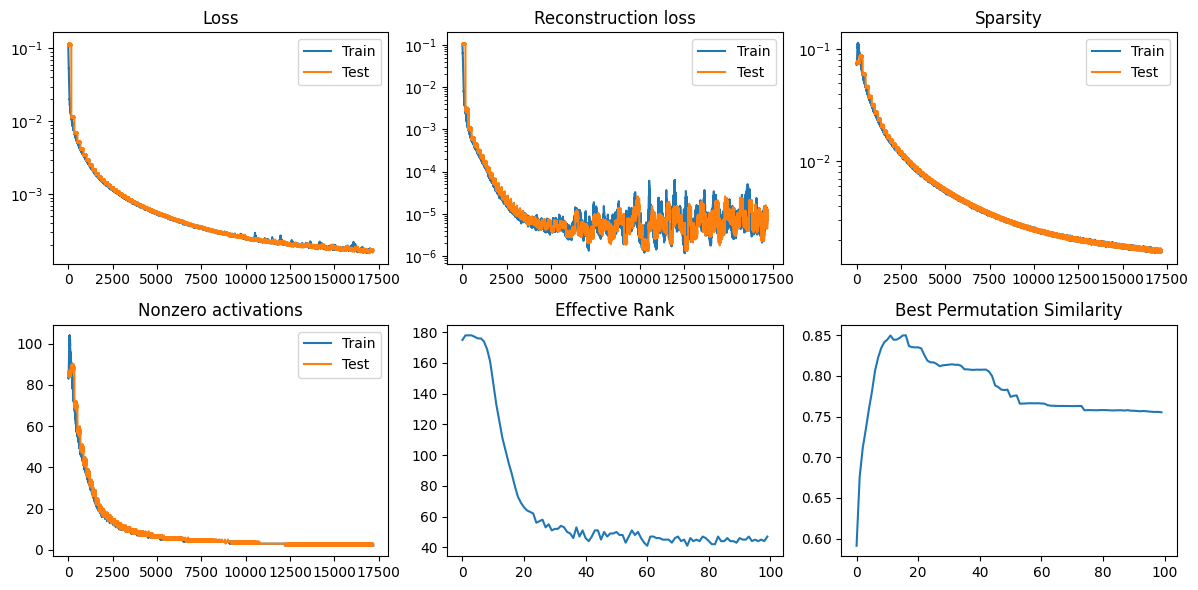

In [19]:
# get 3 x 2 grid of plots 
# loss, recon, sparsity

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

axes[0, 0].plot(losses, label='Train')
axes[0, 0].plot(test_losses, label='Test')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()

axes[0,1].plot(recon_losses, label='Train')
axes[0,1].plot(test_recon_losses, label='Test')
axes[0,1].set_title('Reconstruction loss')
axes[0,1].legend()

axes[0,2].plot(sparsities, label='Train')
axes[0,2].plot(test_sparsities, label='Test')
axes[0,2].set_title('Sparsity')
axes[0,2].legend()

axes[1,0].plot(nnzs, label='Train')
axes[1,0].plot(test_nnzs, label='Test')
axes[1,0].set_title('Nonzero activations')
axes[1,0].legend()

axes[1,1].plot(effective_ranks)
axes[1,1].set_title('Effective Rank')

axes[1,2].plot(ordered_l2)
axes[1,2].set_title('Best Permutation Similarity')

axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[0,2].set_yscale('log')

plt.tight_layout()
plt.show()


In [76]:
# how many neurons are active? 

num_nonzero = torch.sum(test_acts != 0, dim=0)
nnz_idxs = torch.nonzero(num_nonzero).flatten()
# test_acts = test_acts[:, nnz_idxs]
orig_features = torch.tensor(test_set.dataset[test_set.indices])

# get cross covariance matrix between neurons
test_acts_centered = test_acts - test_acts.mean(dim=0, keepdim=True)
orig_features_centered = orig_features - orig_features.mean(dim=0, keepdim=True)

cross_cov_mat = orig_features_centered.T @ test_acts_centered / (test_acts.shape[0] - 1)
nnz_test_acts = test_acts[:, nnz_idxs]
nnz_cross_cov_mat = orig_features_centered.T @ nnz_test_acts / (test_acts.shape[0] - 1)

# check that test_acts is actually sparser

of_sparsity = torch.abs(orig_features).mean(dim=0)
ae_sparsity = torch.abs(nnz_test_acts).mean(dim=0)

print(f"Original features sparsity: {of_sparsity.mean():.3f}")
print(f"Autoencoder activations sparsity: {ae_sparsity.mean():.3f}")

Original features sparsity: 0.096
Autoencoder activations sparsity: 0.006


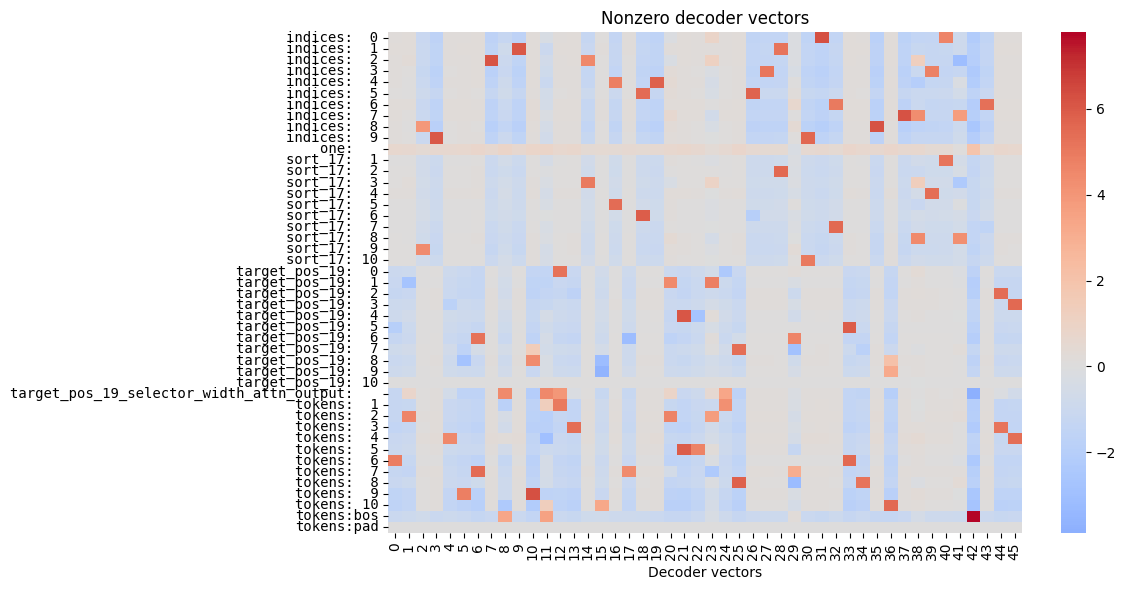

In [77]:
plt.figure(figsize=(12,6))

input_labels = {i for i in range(1, max_seq_len + 1)}
value_width = max(map(len, map(str, input_labels))) + 1

plt.title('Nonzero decoder vectors')
nonzero_decoder_vectors = ae.decoder.weight.data[:, nnz_idxs].T
sns.heatmap(nonzero_decoder_vectors.T, cmap='coolwarm', center=0)
# set y axis label
plt.yticks(
    np.arange(len(assembled_model.residual_labels))+0.5, 
    [tidy_label(l, value_width=value_width)
        for l in assembled_model.residual_labels], 
    family='monospace',
    fontsize=10, rotation=0)

# set x axis label
plt.xlabel('Decoder vectors')

plt.tight_layout()
plt.show()

[31, 9, 7, 27, 19, 26, 43, 37, 35, 3, 42, 40, 28, 14, 39, 16, 18, 32, 38, 2, 30, 12, 23, 44, 45, 21, 33, 6, 25, 10, 36, 41, 11, 24, 20, 13, 4, 22, 0, 17, 34, 5, 15, 8, 1]


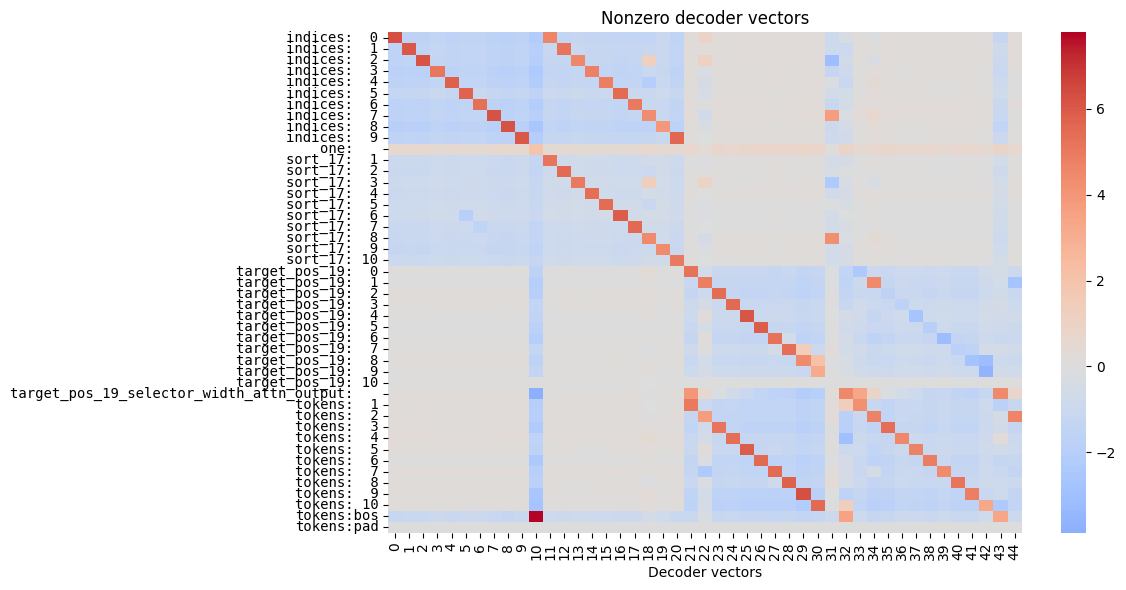

In [78]:
def greedy_similarity_matching(decoder_features): 
    # orders the decoder features by similarity to original features
    # original features are basis aligned
    # decoder_features: (residual_dim, nonzero_decoder_dim)

    basis = torch.eye(decoder_features.shape[0])
    cosine_similarities = (basis @ decoder_features) / (torch.linalg.norm(basis, dim=1)[:, None] * torch.linalg.norm(decoder_features, dim=0)[None, :])
    cosine_similarities = cosine_similarities.T
    # print(cosine_similarities.shape)

    # plt.figure(figsize=(12,6))
    # plt.title('Cosine similarities between basis and decoder features')
    # sns.heatmap(cosine_similarities.T, cmap='coolwarm', center=0)
    # plt.tight_layout()
    # plt.show()

    # greedy reshuffling
    decoder_idxs = []
    for i in range(cosine_similarities.shape[0]): 
        idx = torch.argmax(cosine_similarities[i])
        decoder_idxs.append(idx.item())
        cosine_similarities[:, idx] = 0
    
    return decoder_idxs

reshuffled_idxs = greedy_similarity_matching(nonzero_decoder_vectors)
print(reshuffled_idxs)
plt.figure(figsize=(12,6))

plt.title('Nonzero decoder vectors')
reshuffled = nonzero_decoder_vectors[reshuffled_idxs]
sns.heatmap(reshuffled.T, cmap='coolwarm', center=0)

# set y axis label

plt.yticks(
    np.arange(len(assembled_model.residual_labels))+0.5, 
    [tidy_label(l, value_width=value_width)
        for l in assembled_model.residual_labels], 
    family='monospace',
    fontsize=10, rotation=0)

# set x axis label
plt.xlabel('Decoder vectors')

plt.tight_layout()
plt.show()

### Test with PCA

In [56]:
# apply PCA to all residuals

print(all_residuals.shape)
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca.fit(all_residuals)
pca_residuals = pca.transform(all_residuals)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

plt.bar(range(len(all_residuals[0])), all_residuals.sum(0))
plt.show()

plt.bar(range(len(pca_residuals[0])), pca_residuals.sum(0))
plt.show()

print('L1 of all residuals: ', np.linalg.norm(all_residuals, ord=1, axis=1).mean())
print('L1 of pca residuals: ', np.linalg.norm(pca_residuals, ord=1, axis=1).mean())

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [ ]:
# learn a full rank rotation matrix of the pca residuals that minimizes the projected l1 norm

projection = nn.Linear(pca_residuals.shape[1], pca_residuals.shape[1], bias=False)

In [57]:
# print MSE loss

encoded = pca.encoder(torch_dataset)
decoded = pca.decoder(encoded)
loss = nn.MSELoss()(decoded, torch_dataset)
print(f"MSE Loss: {loss.item():.3f}")

MSE Loss: 0.001


In [43]:
torch_dataset = torch.tensor(pca_residuals, dtype=torch.float32)
batch_size = 128

train_set, test_set = torch.utils.data.random_split(pca_residuals, [len(pca_residuals) // 2, len(pca_residuals) // 2])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

ae = AutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

epochs = 100

losses, recon_losses, sparsities, nnzs = [], [], [], []
test_losses, test_recon_losses, test_sparsities, test_nnzs = [], [], [], []
effective_ranks, ordered_l2 = [], []

pbar = tqdm(range(epochs))
for epoch in pbar:

    test_acts = []
    with torch.no_grad():
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, test_act = ae.loss(batch)
            test_losses.append(test_loss.item())
            test_recon_losses.append(test_recon_loss.item())
            test_sparsities.append(test_sparsity.item())
            test_nnzs.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())
    test_acts = torch.cat(test_acts, dim=0)
    num_nonzero = torch.sum(test_acts != 0, dim=0)
    nnz_idxs = torch.nonzero(num_nonzero).squeeze()
    effective_rank = torch.linalg.matrix_rank(test_acts[:, nnz_idxs])
    effective_ranks.append(effective_rank.item())
    permutation, distance = hungarian(orig_features, test_acts)
    ordered_l2.append(distance)

    for batch in train_loader:
        optimizer.zero_grad()
        loss, recon_loss, sparsity, nnz, _ = ae.loss(batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        sparsities.append(sparsity.item())
        nnzs.append(nnz.item())

    pbar.set_description(f"Loss: {loss.item():.3f}, Recon: {recon_loss.item():.3f}, Sparsity: {sparsity.item():.3f}, NNZ: {nnz.item():.3f}, Effective Rank: {effective_rank.item():.3f}, Distance: {distance:.3f}")

Loss: 0.000, Recon: 0.000, Sparsity: 0.002, NNZ: 2.000, Effective Rank: 43.000, Distance: 0.077: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


In [44]:
# how many neurons are active? 

num_nonzero = torch.sum(test_acts != 0, dim=0)
nnz_idxs = torch.nonzero(num_nonzero).flatten()
# test_acts = test_acts[:, nnz_idxs]
orig_features = torch.tensor(test_set.dataset[test_set.indices])

# get cross covariance matrix between neurons
test_acts_centered = test_acts - test_acts.mean(dim=0, keepdim=True)
orig_features_centered = orig_features - orig_features.mean(dim=0, keepdim=True)

cross_cov_mat = orig_features_centered.T @ test_acts_centered / (test_acts.shape[0] - 1)
nnz_test_acts = test_acts[:, nnz_idxs]
nnz_cross_cov_mat = orig_features_centered.T @ nnz_test_acts / (test_acts.shape[0] - 1)

# check that test_acts is actually sparser

of_sparsity = torch.abs(orig_features).mean(dim=0)
ae_sparsity = torch.abs(nnz_test_acts).mean(dim=0)

print(f"Original features sparsity: {of_sparsity.mean():.3f}")
print(f"Autoencoder activations sparsity: {ae_sparsity.mean():.3f}")

Original features sparsity: 0.162
Autoencoder activations sparsity: 0.006


## Feature similarity vs data frequency

In [101]:
max_seq_len = 10
program_name = 'sort_unique'

def get_permutations(nums): 
    if len(nums) == 1:
        return [nums[:]]
        
    res = []

    for _ in range(len(nums)):
        n = nums.pop(0)
        perms = get_permutations(nums)

        for p in perms:
            p.append(n)
        
        res.extend(perms)
        nums.append(n)
    
    return res

dataset = get_permutations([1,2,4,5,6,7,8,9,10])
dataset = [['bos'] + list(d) for d in dataset]

threes_dataset = get_permutations([1,2,3,4,5,6,7,8,9,10])
threes_dataset = [['bos'] + list(d) for d in threes_dataset]

# shuffle
np.random.shuffle(dataset)
np.random.shuffle(threes_dataset)
dataset, threes_dataset = dataset[:1000], threes_dataset[:1000]

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
    program=program,
    vocab=vocab,
    max_seq_len=max_seq_len,
    causal=False,
    compiler_bos="bos",
    compiler_pad="pad",
    mlp_exactness=100
)

residuals, threes_residuals = [], []
layer_outputs, threes_layer_outputs = [], []

for d, t in zip(tqdm(dataset), tqdm(threes_dataset)):
        output = assembled_model.apply(d)
        residuals.append(output.residuals)
        layer_outputs.append(output.layer_outputs)
        decoded = output.decoded[1:]
        check = sorted(d[1:])
        assert decoded == check, f"Expected {check}, got {decoded}"
        output = assembled_model.apply(t)
        threes_residuals.append(output.residuals)
        threes_layer_outputs.append(output.layer_outputs)
        decoded = output.decoded[1:]
        check = sorted(t[1:])
        assert decoded == check, f"Expected {check}, got {decoded}"
      

layer_outputs = np.array(layer_outputs).squeeze()
residuals = np.array(residuals).squeeze() 
threes_layer_outputs = np.array(threes_layer_outputs).squeeze()
threes_residuals = np.array(threes_residuals).squeeze()

Compiling...
   Program: sort_unique
   Input vocabulary: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
   Context size: 10


100%|█████████▉| 999/1000 [01:14<00:00, 13.44it/s]


In [102]:
def feature_similarity(orig_feature, decoder_features): 
    """
    Returns the max cosine similarity between the original feature and
    the decoder features.

    orig_feature: (residual_dim)
    decoder_features: (residual_dim, decoder_dim)
    """

    cosine_similarities = (orig_feature @ decoder_features) / (torch.linalg.norm(orig_feature) * torch.linalg.norm(decoder_features, dim=0))
    return cosine_similarities.max().item()

In [122]:
total_size = 1000
fracs = [0, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1]

# metrics to track, all test
losses, recon_losses, sparsities, nnzs = [], [], [], []
effective_ranks, ordered_l2 = [], []
three_similarities = {f: [] for f in fracs}

feature_index = 13
sort_3_feature = torch.zeros(orig_features.shape[-1], dtype=torch.float32)
sort_3_feature[feature_index] = 1

for frac in tqdm(fracs):
    residuals, threes_residuals = np.reshape(residuals, (-1, residuals.shape[-1])), np.reshape(threes_residuals, (-1, threes_residuals.shape[-1]))
    mix = np.concatenate([threes_residuals[:int(frac * total_size)], residuals[int(frac * total_size):]], axis=0)
    np.random.shuffle(mix)

    torch_dataset = torch.tensor(mix, dtype=torch.float32)
    batch_size = 128

    train_set, test_set = torch.utils.data.random_split(mix, [len(mix) // 2, len(mix) // 2])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    orig_features = torch.tensor(test_set.dataset[test_set.indices])

    ae = AutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

    epochs = 100

    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            optimizer.zero_grad()
            loss, recon_loss, sparsity, nnz, _ = ae.loss(batch)
            loss.backward()
            optimizer.step()
        
        threes_similarity = feature_similarity(sort_3_feature, ae.decoder.weight.data)
        three_similarities[frac].append(threes_similarity)

    with torch.no_grad():
        loss, recon_loss, sparsity, nnz, test_acts = [], [], [], [], []
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, test_act = ae.loss(batch)
            loss.append(test_loss.item())
            recon_loss.append(test_recon_loss.item())
            sparsity.append(test_sparsity.item())
            nnz.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())
        test_acts = torch.cat(test_acts, dim=0)
        num_nonzero = torch.sum(test_acts != 0, dim=0)
        nnz_idxs = torch.nonzero(num_nonzero).squeeze()
        effective_rank = torch.linalg.matrix_rank(test_acts[:, nnz_idxs])
        permutation, distance = greedy_distributional_distance(orig_features, test_acts)
        effective_ranks.append(effective_rank.item())
        ordered_l2.append(distance)

        losses.append(np.mean(loss))
        recon_losses.append(np.mean(recon_loss))
        sparsities.append(np.mean(sparsity))
        nnzs.append(np.mean(nnz))


100%|██████████| 10/10 [03:06<00:00, 18.67s/it]


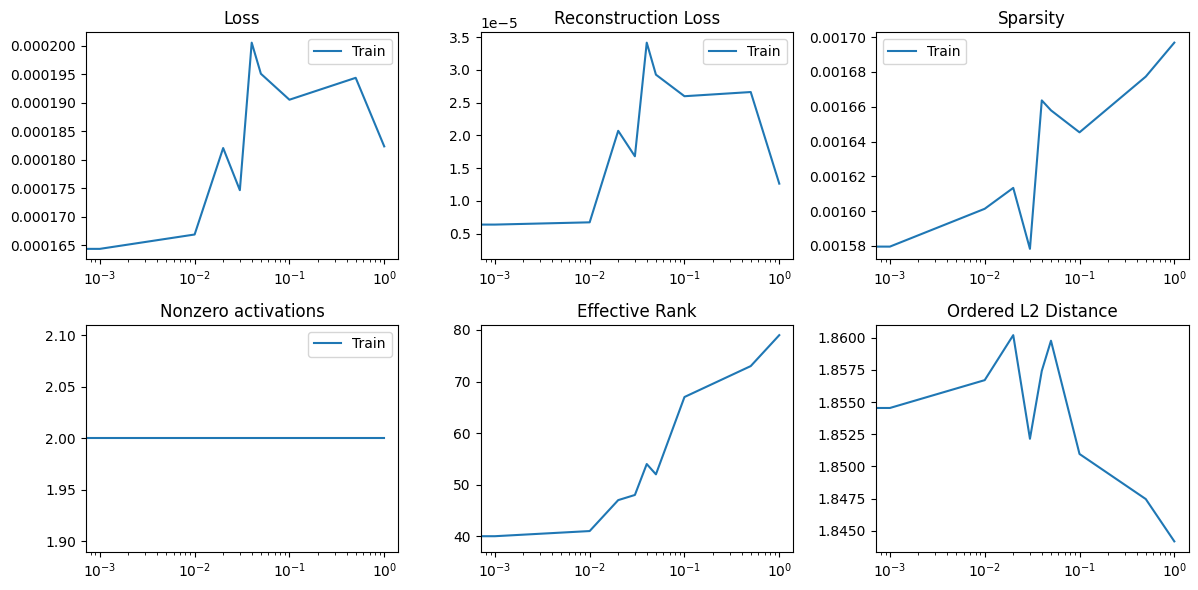

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

axes[0, 0].plot(fracs, losses, label='Train')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()

axes[0,1].plot(fracs, recon_losses, label='Train')
axes[0,1].set_title('Reconstruction Loss')
axes[0,1].legend()

axes[0,2].plot(fracs, sparsities, label='Train')
axes[0,2].set_title('Sparsity')
axes[0,2].legend()

axes[1,0].plot(fracs, nnzs, label='Train')
axes[1,0].set_title('Nonzero activations')
axes[1,0].legend()

axes[1,1].plot(fracs, effective_ranks)
axes[1,1].set_title('Effective Rank')

axes[1,2].plot(fracs, ordered_l2)
axes[1,2].set_title('Ordered L2 Distance')

axes[0,0].set_xscale('log')
axes[0,1].set_xscale('log')
axes[0,2].set_xscale('log')
axes[1,0].set_xscale('log')
axes[1,1].set_xscale('log')
axes[1,2].set_xscale('log')

plt.tight_layout()
plt.show()


In [124]:
three_similarities

{0: [0.16050052642822266],
 0.001: [0.10877464711666107],
 0.01: [0.11963360756635666],
 0.02: [0.08480486273765564],
 0.03: [0.5708999037742615],
 0.04: [0.6249833106994629],
 0.05: [0.12134388089179993],
 0.1: [0.6841525435447693],
 0.5: [0.9754927158355713],
 1: [0.7558759450912476]}

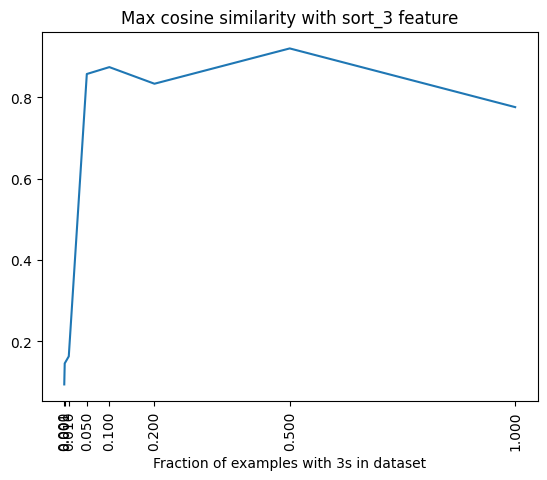

In [111]:
# get 3d plot with epochs on x axis, frac on y axis, and three similarity on z axis

plt.figure(figsize=(12,6))
plt.title('Max cosine_similarity with the sort_3 feature')


Explained variance ratio with 30 dimensions: 1.000


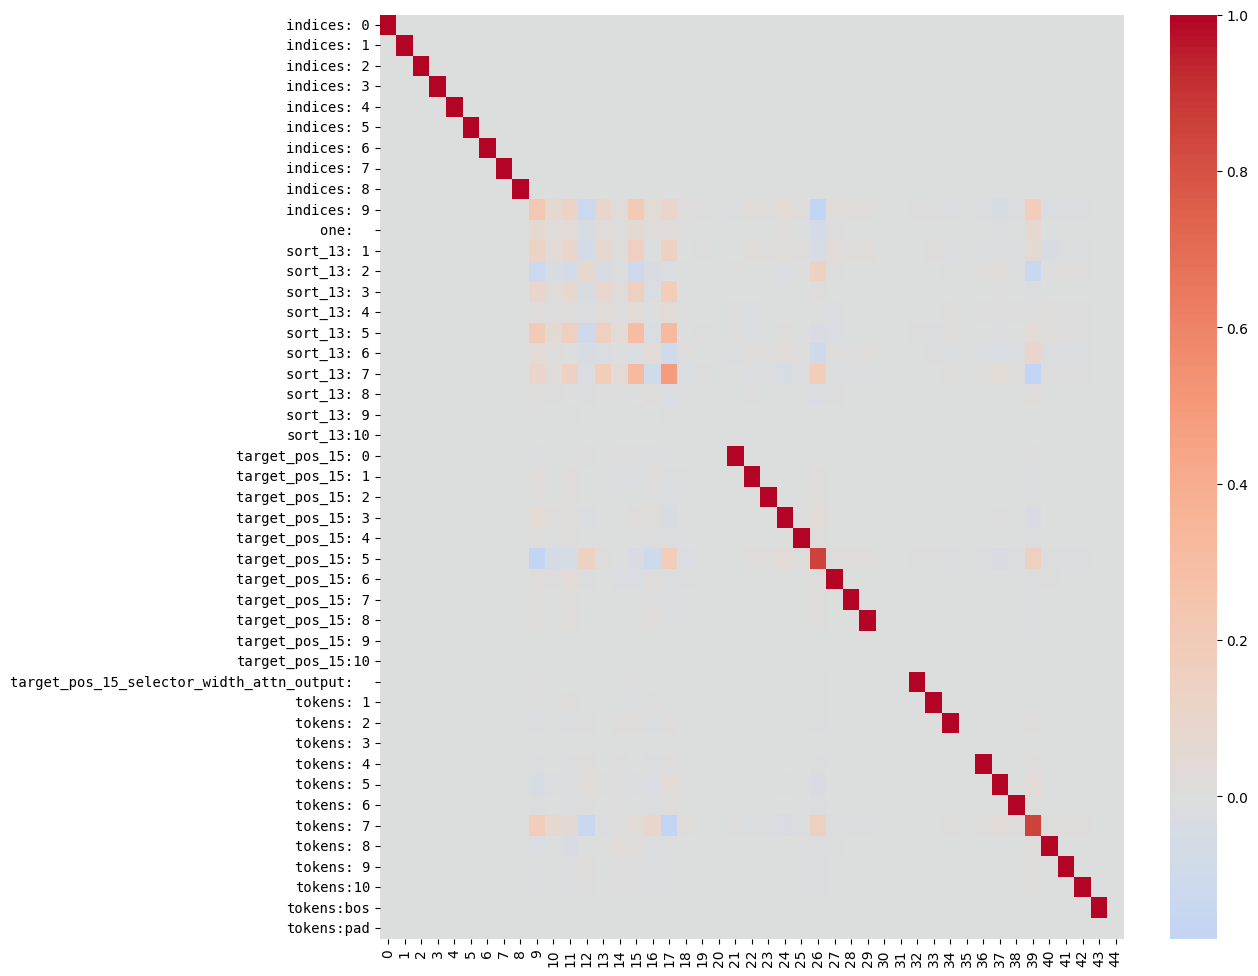

(5, 1, 11, 45)


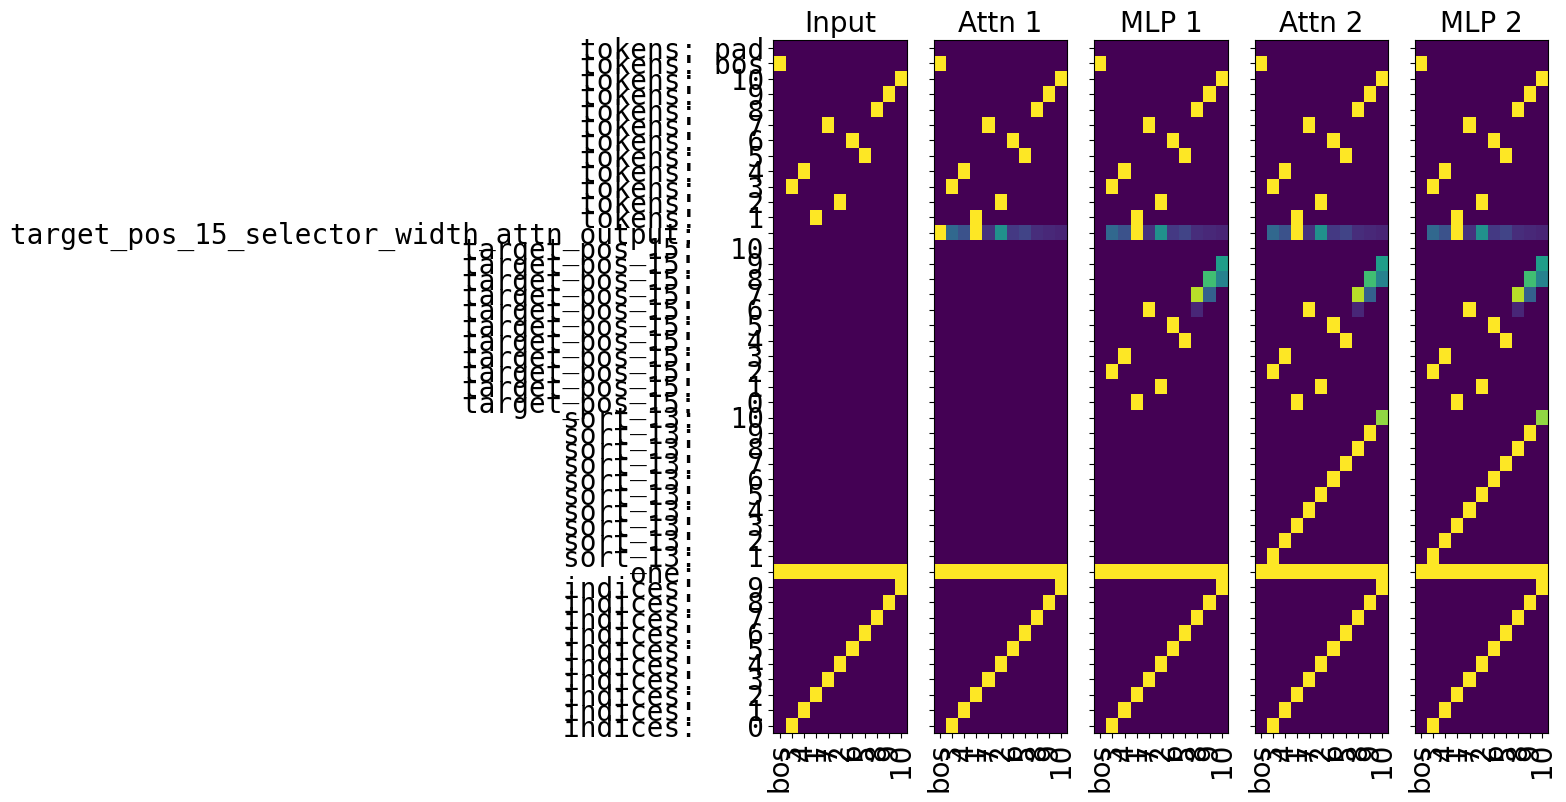

In [57]:
from sklearn.decomposition import PCA

pre_pca = residuals[:,1].reshape(-1, residuals.shape[-1])

# for dim in range(1, pre_pca.shape[-1]): 
#     pca = PCA(n_components=dim, random_state=0, svd_solver='full', whiten=False)
#     pca.fit(pre_pca)
#     print(f"Explained variance ratio with {dim} dimensions: {pca.explained_variance_ratio_.sum():.3f}")

dim = 30
pca = PCA(n_components=dim, random_state=0, svd_solver='full', whiten=False)
pca.fit(pre_pca)
print(f"Explained variance ratio with {dim} dimensions: {pca.explained_variance_ratio_.sum():.3f}")

pca_W = torch.tensor(pca.components_.T, dtype=torch.float32)
pca_b = torch.tensor(pca.mean_, dtype=torch.float32)

plt.figure(figsize=(12,12))
sns.heatmap(pca_W @ pca_W.T, cmap='coolwarm', center=0)
plt.yticks(
    np.arange(len(assembled_model.residual_labels))+0.5, 
    [tidy_label(l, value_width=value_width)
        for l in assembled_model.residual_labels], 
    family='monospace',
    fontsize=10, rotation=0)

plt.show()

# plot_residuals_and_input(
#   model=assembled_model,
#   inputs=["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10],
#   figsize=(10, 9), 
#   pca = None,
# )

plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10],
  figsize=(10, 9), 
  pca = None,
)

## Using anthropic's autoencoder setup

In [ ]:
class AnthropicAutoEncoder(nn.Module): 

    def __init__(self, input_dim, hidden_dim, l1_coeff): 

        super(AnthropicAutoEncoder, self).__init__()
        stdv = 1. / np.sqrt(input_dim)
        # init with uniform distribution
        self.W_enc = nn.Parameter(torch.empty(input_dim, hidden_dim).uniform_(-stdv, stdv))
        self.W_dec = nn.Parameter(torch.empty(hidden_dim, input_dim).uniform_(-stdv, stdv))
        self.b_enc = nn.Parameter(torch.empty(hidden_dim).uniform_(-stdv, stdv))
        self.b_dec = nn.Parameter(torch.empty(input_dim).uniform_(-stdv, stdv))

        self.l1_coeff = l1_coeff
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def forward(self, x): 

        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        encoded = acts @ self.W_dec + self.b_dec
        l2_loss = nn.MSELoss()(encoded, x)
        l1_loss = (acts.float().abs().mean())
        loss = l2_loss + l1_loss * self.l1_coeff
        nnz = torch.sum(acts != 0) // acts.shape[0]
        return loss, l2_loss, l1_loss, nnz, encoded, acts

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        self.W_dec.data = W_dec_normed

anthropic_ae = AnthropicAutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

epochs = 100

losses, recon_losses, sparsities, nnzs = [], [], [], []
test_losses, test_recon_losses, test_sparsities, test_nnzs, test_acts = [], [], [], [], []

pbar = tqdm(range(epochs))
for epoch in pbar:
    for batch in train_loader:
        optimizer.zero_grad()
        loss, recon_loss, sparsity, nnz, _, _ = anthropic_ae(batch)
        loss.backward()
        # anthropic_ae.make_decoder_weights_and_grad_unit_norm()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        sparsities.append(sparsity.item())
        nnzs.append(nnz.item())

    with torch.no_grad():
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, _, test_act = anthropic_ae(batch)
            test_losses.append(test_loss.item())
            test_recon_losses.append(test_recon_loss.item())
            test_sparsities.append(test_sparsity.item())
            test_nnzs.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())

    pbar.set_description(f"Loss: {loss.item():.3f}, Recon: {recon_loss.item():.3f}, Sparsity: {sparsity.item():.3f}, NNZ: {nnz.item():.3f}")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

axes[0].plot(losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(recon_losses, label='Train')
axes[1].plot(test_recon_losses, label='Test')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()

axes[2].plot(sparsities, label='Train')
axes[2].plot(test_sparsities, label='Test')
axes[2].set_title('Sparsity')
axes[2].legend()

axes[3].plot(nnzs, label='Train')
axes[3].plot(test_nnzs, label='Test')
axes[3].set_title('Nonzero activations')
axes[3].legend()

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# how many neurons are active? 

test_acts = []
nnz_idxs = set()

with torch.no_grad():
    for batch in test_loader:
        test_loss, test_recon_loss, test_sparsity, test_nnz, _, test_act = anthropic_ae(batch)
        idxs = torch.nonzero(test_act).flatten()
        nnz_idxs.update(idxs.tolist())
        test_acts.append(test_act.detach().cpu())

nnz_idxs = list(nnz_idxs)
test_acts = torch.cat(test_acts, dim=0)
test_acts = test_acts[:, nnz_idxs]
orig_features = torch.tensor(test_set.dataset[test_set.indices])

# get cross covariance matrix between neurons
test_acts_centered = test_acts - test_acts.mean(dim=0, keepdim=True)
orig_features_centered = orig_features - orig_features.mean(dim=0, keepdim=True)

cross_cov_mat = orig_features_centered.T @ test_acts_centered / (test_acts.shape[0] - 1)

num_nonzero = torch.sum(cross_cov_mat != 0, dim=0)
nonzero_idxs = torch.nonzero(num_nonzero).flatten()
nnz_cross_cov_mat = cross_cov_mat[:, nonzero_idxs]

# put both heatmaps side by side 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(cross_cov_mat, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Cross covariance matrix')

sns.heatmap(nnz_cross_cov_mat, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Cross covariance matrix with zero columns removed')

plt.tight_layout()
plt.show()

## Compressed Model

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns 
import haiku as hk

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

from scipy.optimize import linear_sum_assignment

In [2]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [3]:
#@title: Assemble model
program_name = "sort_unique"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 10 #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

from tracr.datasets.generated_lib import program_1
assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      use_dropout=False, 
      embedding_size=None,
      unembed_at_every_layer=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

# dict_keys(['token_embed', 'pos_embed', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/value', 'transformer/layer_0/attn/linear', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/query', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/value', 'transformer/layer_1/attn/linear', 'transformer/layer_1/mlp/linear_1', 'transformer/layer_1/mlp/linear_2'])
# dict_keys(['token_embed', 'pos_embed', 'compressed_transformer/layer_0/attn/query', 'compressed_transformer/layer_0/attn/key', 'compressed_transformer/layer_0/attn/value', 'compressed_transformer/layer_0/attn/linear', 'compressed_transformer/layer_0/mlp/linear_1', 'compressed_transformer/layer_0/mlp/linear_2', 'compressed_transformer/layer_1/attn/query', 'compressed_transformer/layer_1/attn/key', 'compressed_transformer/layer_1/attn/value', 'compressed_transformer/layer_1/attn/linear', 'compressed_transformer/layer_1/mlp/linear_1', 'compressed_transformer/layer_1/mlp/linear_2'])


Compiling...
   Program: sort_unique
   Input vocabulary: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
   Context size: 10
Done.


In [4]:
#@title Forward pass
assembled_model.apply(["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10]).decoded
# assembled_model.apply(['bos', 'a', 'b', 'c', 'x']).decoded

['bos', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [5]:
import jax.numpy as jnp

@hk.transform
def forward_fn(inputs): 
    compiled_model = assembled_model.get_compiled_model()
    return compiled_model(inputs)

dummy = jnp.zeros((1, 10), dtype=jnp.int32)
rng = jax.random.PRNGKey(0)
params = forward_fn.init(rng, dummy)
params.keys()
jax.tree_map(lambda x: x.shape, params)

{'compressed_transformer/layer_0/attn/key': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_0/attn/linear': {'b': (45,), 'w': (12, 45)},
 'compressed_transformer/layer_0/attn/query': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_0/attn/value': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_0/mlp/linear_1': {'b': (22,), 'w': (45, 22)},
 'compressed_transformer/layer_0/mlp/linear_2': {'b': (45,), 'w': (22, 45)},
 'compressed_transformer/layer_1/attn/key': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_1/attn/linear': {'b': (45,), 'w': (12, 45)},
 'compressed_transformer/layer_1/attn/query': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_1/attn/value': {'b': (12,), 'w': (45, 12)},
 'compressed_transformer/layer_1/mlp/linear_1': {'b': (22,), 'w': (45, 22)},
 'compressed_transformer/layer_1/mlp/linear_2': {'b': (45,), 'w': (22, 45)},
 'pos_embed': {'embeddings': (11, 45)},
 'token_embed': {'embeddings': (12, 45)}}